In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel

In [2]:
data = pd.read_csv('heart.csv').dropna()

In [3]:
data1 = data[['age', 'trestbps', 'thalach', 'target']]
data1

,age,trestbps,thalach,target
0,63,145,150,1
1,37,130,187,1
2,41,130,172,1
3,56,120,178,1
4,57,120,163,1
...,...,...,...,...
298,57,140,123,0
299,45,110,132,0
300,68,144,141,0
301,57,130,115,0


**Posterior 1**

In [43]:
posterior1_model = CmdStanModel(stan_file='posterior1.stan')
data_model = {'N': len(data1), 'age': data1.iloc[:, 0], 'bps': data1.iloc[:, 1], 'thalach': data1.iloc[:, 2]}
sim = posterior1_model.sample(data=data_model,
                        iter_sampling=1,
                        iter_warmup=1000,
                        chains=1,
                        fixed_param=False,
                        seed=24252)
posterior1 = sim.draws_pd()

22:19:13 - cmdstanpy - INFO - compiling stan file /root/data-analytics/posterior1.stan to exe file /root/data-analytics/posterior1
22:19:31 - cmdstanpy - INFO - compiled model executable: /root/data-analytics/posterior1
22:19:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

22:19:32 - cmdstanpy - INFO - CmdStan done processing.


In [18]:
posterior1

,chain__,iter__,draw__,lp__,accept_stat__,combined_heart_disease_prob[1],combined_heart_disease_prob[2],combined_heart_disease_prob[3],combined_heart_disease_prob[4],combined_heart_disease_prob[5],...,combined_heart_disease_prob[294],combined_heart_disease_prob[295],combined_heart_disease_prob[296],combined_heart_disease_prob[297],combined_heart_disease_prob[298],combined_heart_disease_prob[299],combined_heart_disease_prob[300],combined_heart_disease_prob[301],combined_heart_disease_prob[302],combined_heart_disease_prob[303]
0,1.0,1.0,1.0,0.0,0.0,0.484089,0.169422,0.459511,0.40424,0.24986,...,0.820771,0.412733,0.553838,0.701149,0.218755,0.600548,0.122684,0.574204,0.388655,0.324531


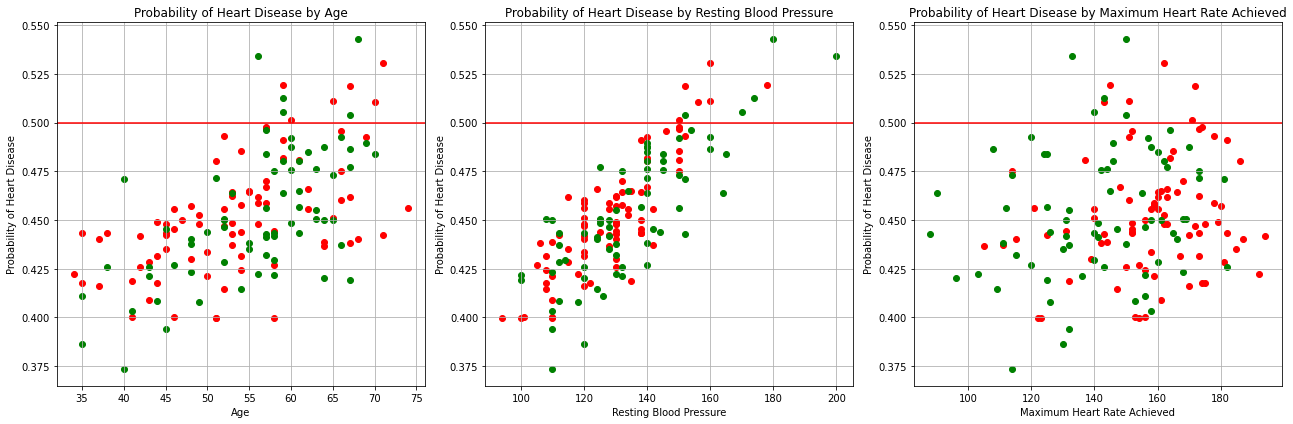

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Probability of heart disease by age
for i in range(len(data1)):
    if i % 2:
        if data1.iloc[i, 3]: # people with heart disease
            axs[0].scatter(data1.iloc[i, 0], posterior1[f"combined_heart_disease_prob[{i + 1}]"], c='r')
        else:                # people without heart disease
            axs[0].scatter(data1.iloc[i, 0], posterior1[f"combined_heart_disease_prob[{i + 1}]"], c='g')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Probability of Heart Disease')
axs[0].set_title('Probability of Heart Disease by Age')
axs[0].axhline(y=0.5, color='red', linestyle='-')
axs[0].grid()

# Plot 2: Probability of heart disease by resting blood pressure
for i in range(len(data1)):
    if i % 2:
        if data1.iloc[i, 3]:
            axs[1].scatter(data1.iloc[i, 1], posterior1[f"combined_heart_disease_prob[{i + 1}]"], c='r')
        else:
            axs[1].scatter(data1.iloc[i, 1], posterior1[f"combined_heart_disease_prob[{i + 1}]"], c='g')
axs[1].set_xlabel('Resting Blood Pressure')
axs[1].set_ylabel('Probability of Heart Disease')
axs[1].set_title('Probability of Heart Disease by Resting Blood Pressure')
axs[1].axhline(y=0.5, color='red', linestyle='-')
axs[1].grid()

# Plot 3: Probability of heart disease by maximum heart rate achieved
for i in range(len(data1)):
    if i % 2:
        if data1.iloc[i, 3]:
            axs[2].scatter(data1.iloc[i, 2], posterior1[f"combined_heart_disease_prob[{i + 1}]"], c='r')
        else:
            axs[2].scatter(data1.iloc[i, 2], posterior1[f"combined_heart_disease_prob[{i + 1}]"], c='g')
axs[2].set_xlabel('Maximum Heart Rate Achieved')
axs[2].set_ylabel('Probability of Heart Disease')
axs[2].set_title('Probability of Heart Disease by Maximum Heart Rate Achieved')
axs[2].axhline(y=0.5, color='red', linestyle='-')
axs[2].grid()

# Adjust layout
plt.tight_layout()
plt.show()